In [6]:
# !pip install librosa

In [1]:
import numpy as np
import pandas as pd
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# to play the audio files
from IPython.display import Audio

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
# from keras.utils import to_categorical # 오류 발생
from keras.models import Sequential
from keras.layers import *
# from keras.optimizers import rmsprop # 오류 발생

from scipy.io import wavfile
from glob import glob
from tqdm import tqdm

## 데이터 전처리

#### 원본 데이터 8등분 후 랜덤으로 병합

In [ ]:
from functools import reduce

# 새로운 오디오 파일을 저장할 디렉토리 경로
output_dir = 'D:\\ds_study\\final\\train_data_5emotions\\new\\슬픔' # 기쁨, 당황, 분노, 불안, 슬픔 순서대로 진행

# 8등분 추출 함수
def extract_chunks(audio_path):
    # 음성 파일 불러오기
    sound = AudioSegment.from_file(audio_path)

    # 음성 데이터 처리
    segment_len = sound.duration_seconds * 1000 / 8
    r_segment_len = round(segment_len)
    chunks = []
    for i in range(8):
        chunk = sound[i*r_segment_len:(i+1)*r_segment_len] # 8등분 자르기
        chunks.append(chunk)

    return chunks

# 반토막 리스트 초기화
pieces = []

for i, audio_path in enumerate(슬픔_df['audio_path']):  # 5감정 df으로 지정해주기
    # 반토막 추출
    chunks = extract_chunks(audio_path)
    piece = pd.DataFrame({'audio_chunk': chunks, 'audio_index': i})
    pieces.append(piece)

# 추출한 반토막들을 합쳐서 새로운 데이터프레임 생성
new_df = pd.concat(pieces)

# 새로운 오디오 파일의 경로를 저장할 리스트 초기화
new_audio_paths = []

# 새로운 오디오 파일 생성
n = 3000 # 생성할 새로운 오디오 파일의 개수
for i in range(n):
    # 랜덤하게 8개의 8등분 선택
    sample = new_df.sample(n=8, replace=False)
    audio_indexes = sample['audio_index'].unique()

 # 8개의 8등분이 모두 다른 파일에서 온 것이면 이어붙이기
    if len(audio_indexes) == 8:
        # 8등분 이어붙이기
        new_chunk = reduce(lambda x, y: x + y, sample['audio_chunk'])

        # 새로운 오디오 파일 경로 생성
        new_audio_path = os.path.join(output_dir, f'new_audio_{i+1}.wav')
        new_audio_paths.append(new_audio_path)

        # 새로운 오디오 파일 저장
        new_chunk.export(new_audio_path, format='wav')

---

#### 데이터 확인

In [2]:
wav_file_list = []
emotion_list = []

for dirname, _, filenames in os.walk('E:/train_data_5by8'):
    for filename in filenames:
        wav_file_list.append(filename)
        emotion_list.append(dirname.split('\\')[1])

In [4]:
len(wav_file_list), len(emotion_list)

(15000, 15000)

In [3]:
df_label = pd.DataFrame({'wav_id': wav_file_list, '감정': emotion_list})
df_label

,wav_id,감정
0,new_audio_1.wav,기쁨
1,new_audio_10.wav,기쁨
2,new_audio_100.wav,기쁨
3,new_audio_1000.wav,기쁨
4,new_audio_1001.wav,기쁨
...,...,...
14995,new_audio_995.wav,슬픔
14996,new_audio_996.wav,슬픔
14997,new_audio_997.wav,슬픔
14998,new_audio_998.wav,슬픔


#### 라벨 인코딩

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [5]:
le.fit(df_label['감정'])

label_encoded_emotions = le.transform(df_label['감정'])
label_encoded_emotions

array([0, 0, 0, ..., 4, 4, 4])

In [6]:
df_label['감정_le'] = label_encoded_emotions
df_label

,wav_id,감정,감정_le
0,new_audio_1.wav,기쁨,0
1,new_audio_10.wav,기쁨,0
2,new_audio_100.wav,기쁨,0
3,new_audio_1000.wav,기쁨,0
4,new_audio_1001.wav,기쁨,0
...,...,...,...
14995,new_audio_995.wav,슬픔,4
14996,new_audio_996.wav,슬픔,4
14997,new_audio_997.wav,슬픔,4
14998,new_audio_998.wav,슬픔,4


In [9]:
df_label['감정'].value_counts()

기쁨    3000
당황    3000
분노    3000
불안    3000
슬픔    3000
Name: 감정, dtype: int64

- 기쁨, 당황, 분노, 불안, 상처, 슬픔, 중립 (가나다)순으로 0, 1, 2, 3, 4, 5, 6

In [10]:
df_label[df_label['감정'] == '슬픔']

,wav_id,감정,감정_le
12000,new_audio_1.wav,슬픔,4
12001,new_audio_10.wav,슬픔,4
12002,new_audio_100.wav,슬픔,4
12003,new_audio_1000.wav,슬픔,4
12004,new_audio_1001.wav,슬픔,4
...,...,...,...
14995,new_audio_995.wav,슬픔,4
14996,new_audio_996.wav,슬픔,4
14997,new_audio_997.wav,슬픔,4
14998,new_audio_998.wav,슬픔,4


In [52]:
# sns.set_style('darkgrid') # seaborn 배경 설정

In [7]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 때문에 한글이 깨질 수 있어 주는 설정

c:\Users\theo\miniconda3\envs\ds_study\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


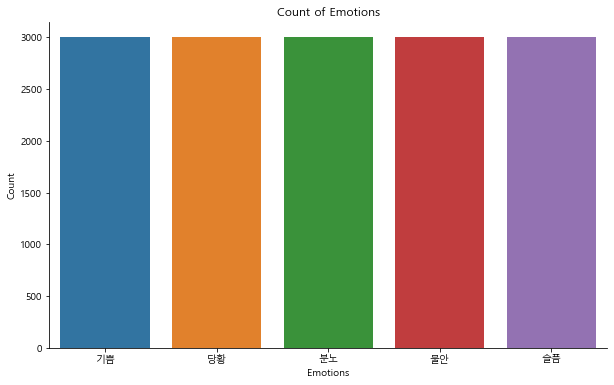

In [12]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions')
sns.countplot(df_label['감정'])
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [55]:
df_label[df_label['감정'] == '기쁨'].head(3)

,wav_id,감정,감정_le
0,new_audio_1.wav,기쁨,0
1,new_audio_10.wav,기쁨,0
2,new_audio_100.wav,기쁨,0


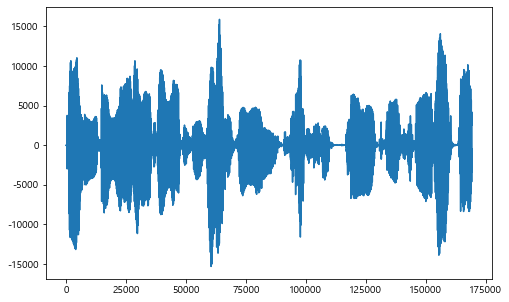

In [13]:
fs, data = wavfile.read('E:/train_data_5by8/기쁨/new_audio_1.wav')
data = np.array(data)

plt.figure(figsize=(8, 5))
plt.plot(data)

Audio('E:/train_data_5by8/기쁨/new_audio_1.wav')

In [27]:
df_label[df_label['감정'] == '당황'].head(3)

,wav_id,감정,감정_le
2000,new_audio_1.wav,당황,1
2001,new_audio_10.wav,당황,1
2002,new_audio_100.wav,당황,1


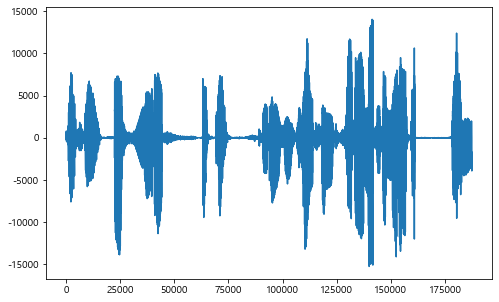

In [14]:
fs, data = wavfile.read('E:/train_data_5by8/당황/new_audio_1.wav')
data = np.array(data)

plt.figure(figsize=(8, 5))
plt.plot(data)

Audio('E:/train_data_5by8/당황/new_audio_1.wav')

In [15]:
df_label[df_label['감정'] == '분노'].head(3)

,wav_id,감정,감정_le
4000,0001_G1A3E3S0C0_PSB_000016.wav,분노,2
4001,0001_G1A3E3S0C0_PSB_000083.wav,분노,2
4002,0001_G1A3E3S0C0_PSB_000095.wav,분노,2


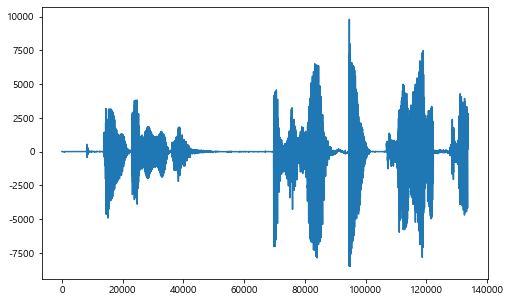

In [15]:
fs, data = wavfile.read('E:/train_data_5by8/분노/new_audio_1.wav')
data = np.array(data)

plt.figure(figsize=(8, 5))
plt.plot(data)

Audio('E:/train_data_5by8/분노/new_audio_1.wav')

In [17]:
df_label[df_label['감정'] == '불안'].head(3)

,wav_id,감정,감정_le
6000,0001_G1A3E4S0C0_PSB_000006.wav,불안,3
6001,0001_G1A3E4S0C0_PSB_000041.wav,불안,3
6002,0001_G1A3E4S0C0_PSB_000057.wav,불안,3


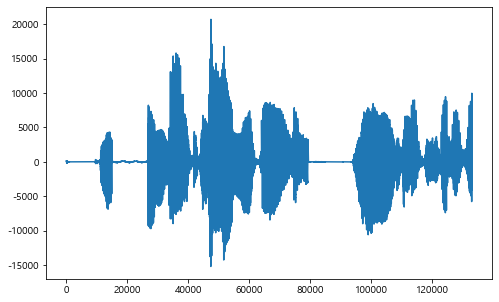

In [16]:
fs, data = wavfile.read('E:/train_data_5by8/불안/new_audio_1.wav')
data = np.array(data)

plt.figure(figsize=(8, 5))
plt.plot(data)

Audio('E:/train_data_5by8/불안/new_audio_1.wav')

In [21]:
df_label[df_label['감정'] == '슬픔'].head(3)

,wav_id,감정,감정_le
10000,0001_0001_G1A3E2S0C0_PSB_000031.wav,슬픔,5
10001,0001_0001_G1A3E2S0C0_PSB_000033.wav,슬픔,5
10002,0001_0001_G1A3E2S0C0_PSB_000051.wav,슬픔,5


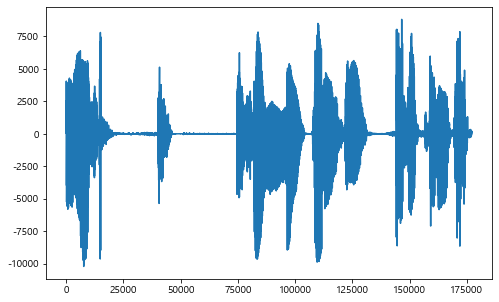

In [18]:
fs, data = wavfile.read('E:/train_data_5by8/슬픔/new_audio_1.wav')
data = np.array(data)

plt.figure(figsize=(8, 5))
plt.plot(data)

Audio('E:/train_data_5by8/슬픔/new_audio_1.wav')

---

## MFCC

#### MFCC 추출 함수

In [13]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

#### 라벨 데이터 생성

In [14]:
df_label.tail()

,wav_id,감정,감정_le
14995,new_audio_995.wav,슬픔,4
14996,new_audio_996.wav,슬픔,4
14997,new_audio_997.wav,슬픔,4
14998,new_audio_998.wav,슬픔,4
14999,new_audio_999.wav,슬픔,4


In [8]:
speech_labels = []

for i in df_label['감정_le']:
    speech_labels.append(i)

In [9]:
len(speech_labels)

15000

#### 음성 데이터 생성

In [17]:
##### 음성 데이터 로드 #####

speech_data = [] # to save extracted features/file
for dirname, _, filenames in os.walk('E:/train_data_5by8'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        wav_file_name = os.path.join(dirname, filename)
        speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file  
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [18]:
len(speech_data)

15000

#### speech_data pkl 파일로 저장

In [28]:
import pickle

# with open('speech_data.pkl', 'wb') as f:
#     pickle.dump(speech_data, f)

In [50]:
# with open('speech_data_copy.pkl', 'wb') as f:
#     pickle.dump(speech_data, f)

In [29]:
# # load
# with open('speech_data.pkl', 'rb') as f:
#     speech_data = pickle.load(f)

In [61]:
speech_data[0].shape

(40,)

In [62]:
speech_data[-1].shape

(40,)

#### 라벨, 음성 데이터 array로 변환

In [19]:
import tensorflow as tf

In [25]:
#### convert data and label to array
speech_data_array = np.asarray(speech_data) # convert the input to an array
speech_label_array = np.array(speech_labels)
speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = tf.keras.utils.to_categorical(speech_label_array) # converts a class vector (integers) to binary class matrix
labels_categorical.shape

(15000, 5)

In [21]:
speech_data_array.shape

(15000, 40)

#### 데이터, 라벨 np.array 파일 npy 파일로 저장

In [ ]:
# # save
# np.save("speech_data_array.npy", speech_data_array)
# np.save("labels_categorical.npy", labels_categorical)
# # load
# speech_data_array = np.load("speech_data_array.npy")
# labels_categorical = np.load("labels_categorical.npy")

#### 모델 평가용 데이터 생성

In [10]:
test_wav_file_list = []
test_emotion_list = []

for dirname, _, filenames in os.walk('E:/test_data_5emotions'):
    for filename in filenames:
        test_wav_file_list.append(filename)
        test_emotion_list.append(dirname.split('_')[3])

In [11]:
len(test_wav_file_list), len(test_emotion_list)

(1500, 1500)

In [12]:
df_test_label = pd.DataFrame({'wav_id': test_wav_file_list, '감정': test_emotion_list})
df_test_label

,wav_id,감정
0,0029_G2A4E1S0C0_KJE_000006.wav,기쁨
1,0029_G2A4E1S0C0_KJE_000044.wav,기쁨
2,0029_G2A4E1S0C0_KJE_000119.wav,기쁨
3,0029_G2A4E1S0C0_KJE_000134.wav,기쁨
4,0029_G2A4E1S0C0_KJE_000188.wav,기쁨
...,...,...
1495,0037_G1A4E2S0C0_SJH_001824.wav,슬픔
1496,0037_G1A4E2S0C0_SJH_001939.wav,슬픔
1497,0037_G1A4E2S0C0_SJH_001952.wav,슬픔
1498,0037_G1A4E2S0C0_SJH_001961.wav,슬픔


In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [14]:
le.fit(df_test_label['감정'])

test_label_encoded_emotions = le.transform(df_test_label['감정'])
test_label_encoded_emotions

array([0, 0, 0, ..., 4, 4, 4])

In [15]:
df_test_label['감정_le'] = test_label_encoded_emotions
df_test_label

,wav_id,감정,감정_le
0,0029_G2A4E1S0C0_KJE_000006.wav,기쁨,0
1,0029_G2A4E1S0C0_KJE_000044.wav,기쁨,0
2,0029_G2A4E1S0C0_KJE_000119.wav,기쁨,0
3,0029_G2A4E1S0C0_KJE_000134.wav,기쁨,0
4,0029_G2A4E1S0C0_KJE_000188.wav,기쁨,0
...,...,...,...
1495,0037_G1A4E2S0C0_SJH_001824.wav,슬픔,4
1496,0037_G1A4E2S0C0_SJH_001939.wav,슬픔,4
1497,0037_G1A4E2S0C0_SJH_001952.wav,슬픔,4
1498,0037_G1A4E2S0C0_SJH_001961.wav,슬픔,4


In [16]:
df_test_label['감정'].value_counts()

기쁨    300
당황    300
분노    300
불안    300
슬픔    300
Name: 감정, dtype: int64

In [17]:
df_test_label[df_test_label['감정'] == '슬픔']

,wav_id,감정,감정_le
1200,0005_G1A3E5S0C0_LJB_000071.wav,슬픔,4
1201,0005_G1A3E5S0C0_LJB_000248.wav,슬픔,4
1202,0005_G1A3E5S0C0_LJB_000253.wav,슬픔,4
1203,0005_G1A3E5S0C0_LJB_000278.wav,슬픔,4
1204,0005_G1A3E5S0C0_LJB_000342.wav,슬픔,4
...,...,...,...
1495,0037_G1A4E2S0C0_SJH_001824.wav,슬픔,4
1496,0037_G1A4E2S0C0_SJH_001939.wav,슬픔,4
1497,0037_G1A4E2S0C0_SJH_001952.wav,슬픔,4
1498,0037_G1A4E2S0C0_SJH_001961.wav,슬픔,4


c:\Users\theo\miniconda3\envs\ds_study\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


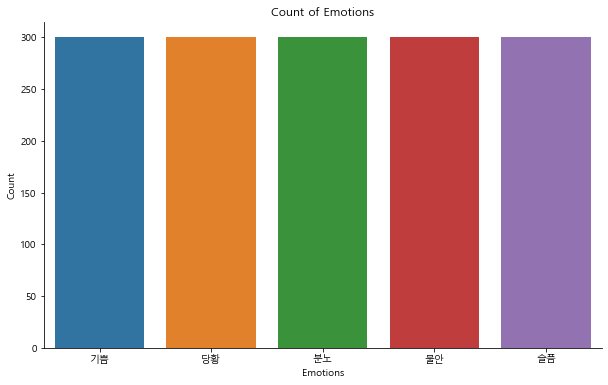

In [30]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions')
sns.countplot(df_test_label['감정'])
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [18]:
speech_labels_test = []

for i in df_test_label['감정_le']:
    speech_labels_test.append(i)

In [32]:
speech_labels_test[0:7]

[0, 0, 0, 0, 0, 0, 0]

In [33]:
##### 음성 데이터 로드 #####

speech_data_test = [] # to save extracted features/file
for dirname, _, filenames in os.walk('E:/test_data_5emotions'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        wav_file_name = os.path.join(dirname, filename)
        speech_data_test.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [34]:
len(speech_data_test)

1500

In [35]:
len(speech_labels_test)

1500

In [36]:
#### Array 전환

#### convert data and label to array
speech_data_test_array = np.asarray(speech_data_test) # convert the input to an array
speech_label_test_array = np.array(speech_labels_test)
speech_label_test_array.shape # get tuple of array dimensions

#### make categorical labels
test_labels_categorical = tf.keras.utils.to_categorical(speech_label_test_array) # converts a class vector (integers) to binary class matrix
test_labels_categorical.shape

(1500, 5)

---

#### 훈련, 테스트 데이터 분할

In [122]:
x_train, x_test, y_train, y_test = train_test_split(np.array(speech_data_array), labels_categorical, test_size=0.20, random_state=13)

### 모델 훈련

In [74]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11287626743049636366
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2954359604
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13176983565659300996
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960M, pci bus id: 0000:02:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


In [ ]:
x_train.shape, x_test.shape

((12000, 40), (3000, 40))

In [ ]:
y_train.shape, y_test.shape

((12000, 5), (3000, 5))

In [124]:
# 반복학습을 피하기 위한 모델 리셋용
tf.keras.backend.clear_session()

## LSTM

In [129]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import TopKCategoricalAccuracy

def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(40, 1)))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(35, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])
    return model

In [130]:
# 반복학습을 피하기 위한 모델 리셋용
tf.keras.backend.clear_session()

In [131]:
LSTM_model = create_model_LSTM()
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 40, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 35)                1

In [132]:
# 최적의 모델을 저장하기 위한 es, mc

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 콜백 함수
es = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=10)

# 최적의 모델을 자동 저장
mc = ModelCheckpoint("LSTM_model.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [133]:
print("GPU를 사용한 학습")
with tf.device("/device:GPU:0"):
  history = LSTM_model.fit(np.expand_dims(x_train,-1), 
                        y_train, 
                        validation_data=(x_test, y_test), 
                        batch_size=32,
                        epochs=100,
                        callbacks=[es, mc],
                        shuffle=True)

GPU를 사용한 학습
Epoch 1/100
373/375 [============================>.] - ETA: 0s - loss: 1.4797 - accuracy: 0.3037 - top_k_categorical_accuracy: 0.5782
Epoch 00001: val_loss improved from inf to 1.35782, saving model to LSTM_model.h5
375/375 [==============================] - 18s 34ms/step - loss: 1.4796 - accuracy: 0.3039 - top_k_categorical_accuracy: 0.5785 - val_loss: 1.3578 - val_accuracy: 0.3320 - val_top_k_categorical_accuracy: 0.6697
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 1.3153 - accuracy: 0.3877 - top_k_categorical_accuracy: 0.7146- ETA: 0s - loss: 1.3194 - accuracy: 0.3851 - top_k_categorical_accu
Epoch 00002: val_loss improved from 1.35782 to 1.25605, saving model to LSTM_model.h5
375/375 [==============================] - 11s 28ms/step - loss: 1.3153 - accuracy: 0.3877 - top_k_categorical_accuracy: 0.7146 - val_loss: 1.2561 - val_accuracy: 0.4227 - val_top_k_categorical_accuracy: 0.7520
Epoch 3/100
373/375 [============================>.] - ETA: 0s

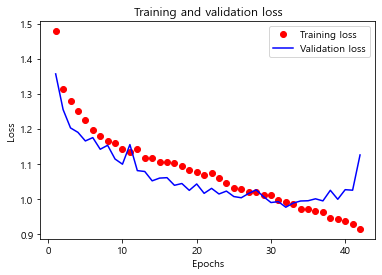

In [134]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

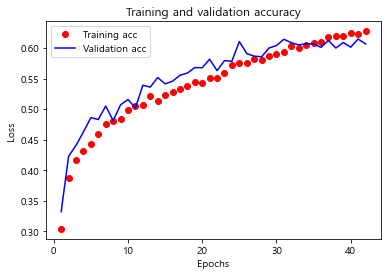

In [135]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

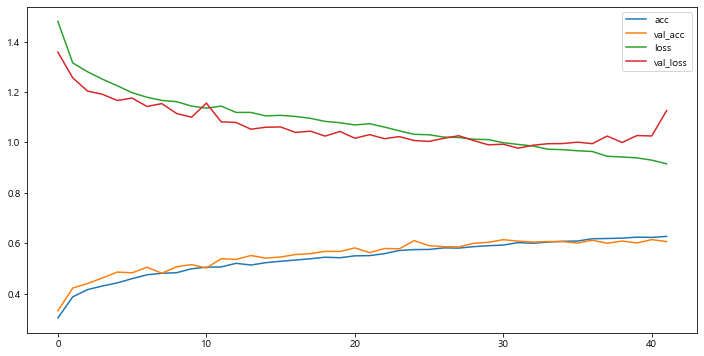

In [136]:
# 수치 비교
plt.figure(figsize=(12,6))
plt.plot(acc, label = 'acc')
plt.plot(val_acc, label = 'val_acc')
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [137]:
# 백업용 모델 로드
LSTM_model = tf.keras.models.load_model('LSTM_model.h5')

#### 테스트 샘플 데이터(1500개) 모델 평가

In [138]:
### evaluate using backup_model
LSTM_model.evaluate(np.expand_dims(speech_data_test_array, -1), test_labels_categorical, batch_size=32)

47/47 [==============================] - 2s 19ms/step - loss: 2.2673 - accuracy: 0.4073 - top_k_categorical_accuracy: 0.7120


[2.2672550678253174, 0.4073333442211151, 0.7120000123977661]

#### Confusion Matrix

In [66]:
from sklearn.metrics import confusion_matrix

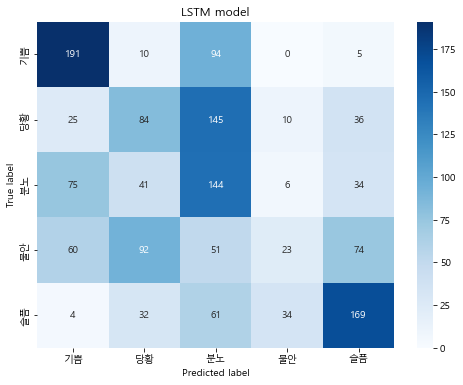

In [200]:
# 모델 LSTM의 예측 결과 가져오기
predictions = LSTM_model.predict(np.expand_dims(speech_data_test_array, -1))
# 각 샘플에서 가장 높은 예측값의 인덱스 가져오기
predicted_labels = np.argmax(predictions, axis=1)
# confusion matrix 계산
cm = confusion_matrix(test_labels_categorical.argmax(axis=1), predicted_labels)
# confusion matrix heatmap 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['기쁨', '당황', '분노', '불안', '슬픔'], yticklabels=['기쁨', '당황', '분노', '불안', '슬픔'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LSTM model')
plt.show()

---

#### 랜덤포레스트

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

RFC_model = RandomForestClassifier(n_estimators=4500, max_depth=50, random_state=13)

RFC_model.fit(speech_data_array, speech_label_array)
pred_RFC= RFC_model.predict(speech_data_test_array)
score= accuracy_score(speech_label_test_array,pred_RFC)
print(f'RandomForestClassifier 모델의 정확도는 {score*100:.2f}% 입니다.')

RandomForestClassifier 모델의 정확도는 41.07% 입니다.


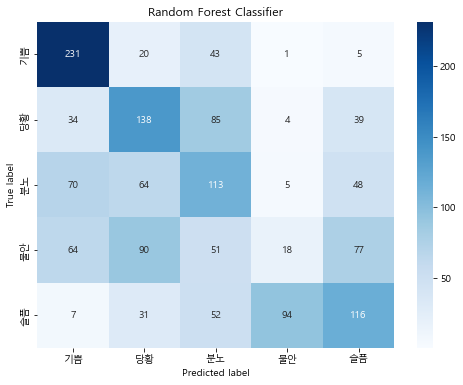

In [202]:
cm = confusion_matrix(test_labels_categorical.argmax(axis=1), pred_RFC)
# confusion matrix heatmap 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['기쁨', '당황', '분노', '불안', '슬픔'], yticklabels=['기쁨', '당황', '분노', '불안', '슬픔'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Classifier')
plt.show()

---

## ResNet

In [62]:
from tensorflow.keras.models import Model
# from tensorflow.keras import Model

In [145]:

def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters_in, kernel_size=1, strides=1, padding="same")(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv1D(filters_in, kernel_size=3, strides=1, padding="same")(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv1D(filters_out, kernel_size=1, strides=1, padding="same")(x)

    shortcut_channel = x.shape.as_list()[-1]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=1, strides=1, padding="same")(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [146]:
def build_model():

  inputs = tf.keras.layers.Input(shape=(40,1))

  outputs = Conv1D(256,5,activation=None,padding='same')(inputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = MaxPool1D(2)(outputs)

  outputs = residual_block(outputs, 20, 256)
  outputs = MaxPool1D(2)(outputs)
  outputs = residual_block(outputs, 10, 256)

  outputs = residual_block(outputs, 10,256)
  outputs = MaxPool1D(2)(outputs)
  outputs = residual_block(outputs, 5, 256)

  outputs = GlobalAveragePooling1D()(outputs)

  outputs = Dense(20,activation=None)(outputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = Dropout(0.5)(outputs)

  outputs = Dense(5,activation='softmax')(outputs)
  
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

  return model

In [144]:
# 반복학습을 피하기 위한 모델 리셋용
tf.keras.backend.clear_session()

In [147]:
# 최적의 모델을 자동 저장
es = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('ResNet_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

#모델 초기화 및 학습
resnet_model=build_model()
print("GPU를 사용한 학습")
with tf.device("/device:GPU:0"):
  history = resnet_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[es,mc], shuffle=True)

GPU를 사용한 학습
Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 1.2871 - accuracy: 0.4408 - top_k_categorical_accuracy: 0.7230
Epoch 00001: val_loss improved from inf to 3.25464, saving model to ResNet_model.h5
375/375 [==============================] - 22s 48ms/step - loss: 1.2871 - accuracy: 0.4408 - top_k_categorical_accuracy: 0.7230 - val_loss: 3.2546 - val_accuracy: 0.2103 - val_top_k_categorical_accuracy: 0.4143
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 1.1115 - accuracy: 0.5222 - top_k_categorical_accuracy: 0.8068
Epoch 00002: val_loss improved from 3.25464 to 2.54750, saving model to ResNet_model.h5
375/375 [==============================] - 17s 46ms/step - loss: 1.1115 - accuracy: 0.5222 - top_k_categorical_accuracy: 0.8068 - val_loss: 2.5475 - val_accuracy: 0.2850 - val_top_k_categorical_accuracy: 0.4877
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.5347 - top_k_categorical_accuracy:

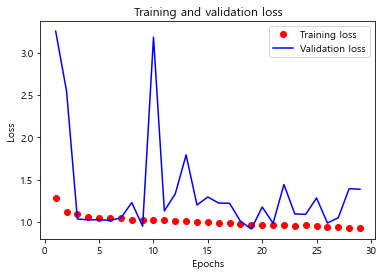

In [149]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

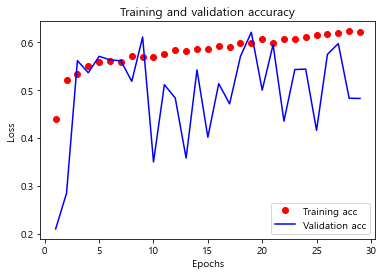

In [150]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

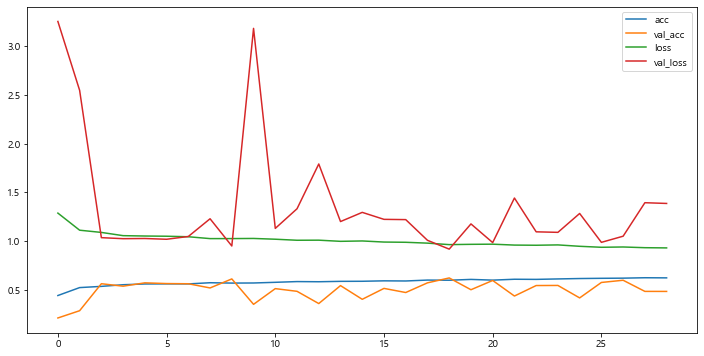

In [151]:
# 수치 비교
plt.figure(figsize=(12,6))
plt.plot(acc, label = 'acc')
plt.plot(val_acc, label = 'val_acc')
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [152]:
# 백업용 모델 로드
resnet_model = tf.keras.models.load_model('ResNet_model.h5')

#### 테스트 샘플 데이터(1500개) 모델 평가

In [153]:
### evaluate using backup_model
resnet_model.evaluate(np.expand_dims(speech_data_test_array, -1), test_labels_categorical, batch_size=32)

47/47 [==============================] - 2s 27ms/step - loss: 1.9661 - accuracy: 0.4653 - top_k_categorical_accuracy: 0.6967


[1.9660533666610718, 0.46533334255218506, 0.6966666579246521]

#### Confusion Matrix

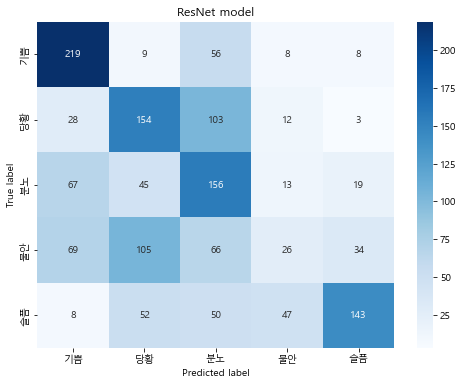

In [203]:
# ResNet 모델의 예측 결과 가져오기
predictions = resnet_model.predict(np.expand_dims(speech_data_test_array, -1))
# 각 샘플에서 가장 높은 예측값의 인덱스 가져오기
predicted_labels = np.argmax(predictions, axis=1)
# confusion matrix 계산
cm = confusion_matrix(test_labels_categorical.argmax(axis=1), predicted_labels)
# confusion matrix heatmap 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['기쁨', '당황', '분노', '불안', '슬픔'], yticklabels=['기쁨', '당황', '분노', '불안', '슬픔'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('ResNet model')
plt.show()

---

## EfficientNet

In [19]:
from sklearn.preprocessing import MinMaxScaler
import cv2

In [20]:
#MEL SPEC으로 음성데이터 이미지화
def extract_mel(f_path):
    data, sample_rate = librosa.load(os.path.join(f_path))
    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=data, sr=16550).T
    mel = librosa.power_to_db(mel, ref=np.max)
    # Rescale Mel Spectrogram data to range [0, 255]
    scaler = MinMaxScaler(feature_range=(0, 255))
    mel_scaled = scaler.fit_transform(mel)
    mel_scaled = mel_scaled.astype('uint8')
    # Resize Mel Spectrogram data to shape (224, 224)
    result = cv2.resize(mel_scaled, (224, 224))
    return result

In [21]:
##### 음성 데이터 로드 #####

speech_data_mel = [] # to save extracted features/file
for dirname, _, filenames in os.walk('E:/train_data_5by8'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        wav_file_name = os.path.join(dirname, filename)
        speech_data_mel.append(extract_mel(wav_file_name)) # extract MFCC features/file  
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [22]:
#### Array 전환

speech_data_mel_array = np.asarray(speech_data_mel) # convert the input to an array

In [23]:
speech_data_mel_array.shape

(15000, 224, 224)

In [26]:
# 라벨
labels_categorical.shape

(15000, 5)

In [27]:
# Splitting Data
x_train_CNN, x_test_CNN, y_train_CNN, y_test_CNN = train_test_split(speech_data_mel_array, labels_categorical, test_size=0.2, random_state=0, shuffle=True)
x_train_CNN.shape, y_train_CNN.shape, x_test_CNN.shape, y_test_CNN.shape

((12000, 224, 224), (12000, 5), (3000, 224, 224), (3000, 5))

In [28]:
x_train_CNN.shape[1]

224

In [29]:
# 입력 이미지 shape 변경
x_train_CNN = np.expand_dims(x_train_CNN, axis=-1)
x_test_CNN = np.expand_dims(x_test_CNN, axis=-1)
print(x_train_CNN.shape, y_train_CNN.shape, x_test_CNN.shape, y_test_CNN.shape)

(12000, 224, 224, 1) (12000, 5) (3000, 224, 224, 1) (3000, 5)


In [30]:
# 채널수 3으로 수정
x_train_CNN = np.repeat(x_train_CNN, 3, axis=-1)
x_test_CNN = np.repeat(x_test_CNN, 3, axis=-1)

In [31]:
x_train_CNN.shape, y_train_CNN.shape, x_test_CNN.shape, y_test_CNN.shape

((12000, 224, 224, 3), (12000, 5), (3000, 224, 224, 3), (3000, 5))

In [32]:
y_train_CNN

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [60]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [61]:
#efficientNet
def EfficientNet(input_shape, classes):
    # EfficientNetB0 모델 로드
    base_model = EfficientNetB0(input_shape=input_shape,
                                include_top=False, weights='imagenet')
    # 새로운 레이어 추가
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(classes, activation='softmax')(x)
    # 새로운 모델 생성
    model = Model(inputs=base_model.input, outputs=predictions)
    # EfficientNetB0 모델의 일부 레이어를 학습하지 않도록 설정
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])
    
    return model

In [58]:
# 반복학습을 피하기 위한 모델 리셋용
tf.keras.backend.clear_session()

In [46]:
efficentNet_model=EfficientNet((224, 224, 3), 5)
efficentNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


history2=model.fit(x_train, y_train, shuffle=True, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp,early_stop])

Epoch 1/100
188/188 [==============================] - 772s 4s/step - loss: 1.4745 - accuracy: 0.3492 - val_loss: 1.3713 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 2/100
188/188 [==============================] - 722s 4s/step - loss: 1.3885 - accuracy: 0.3998 - val_loss: 1.3477 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 3/100
188/188 [==============================] - 782s 4s/step - loss: 1.3538 - accuracy: 0.4167 - val_loss: 1.3030 - val_accuracy: 0.4507 - lr: 0.0010
Epoch 4/100
188/188 [==============================] - 673s 4s/step - loss: 1.3349 - accuracy: 0.4301 - val_loss: 1.3057 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 5/100
188/188 [==============================] - 665s 4s/step - loss: 1.3245 - accuracy: 0.4424 - val_loss: 1.2805 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 6/100
188/188 [==============================] - 633s 3s/step - loss: 1.3103 - accuracy: 0.4449 - val_loss: 1.2999 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 7/100
188/188 [==============================] - 634

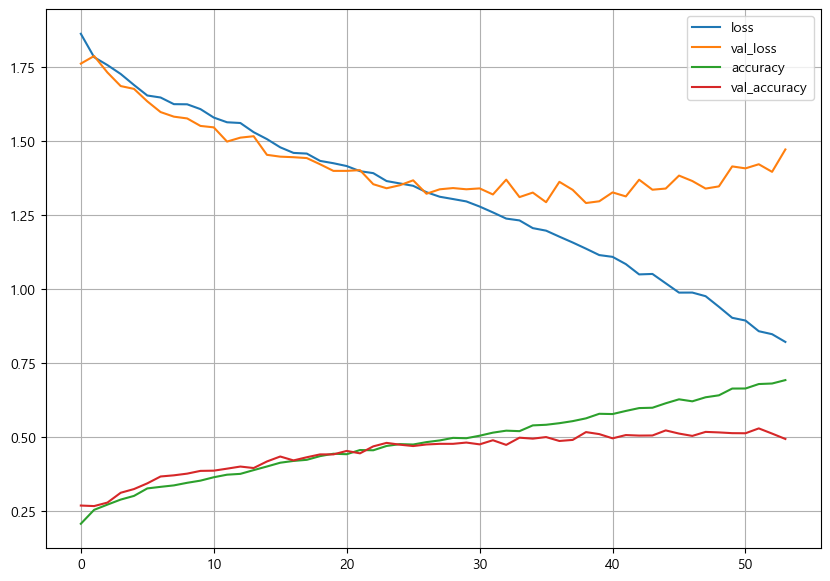

In [ ]:
plot_target = ['loss','val_loss','accuracy','val_accuracy']
plt.figure(figsize=(10,7))
for each in plot_target:
    plt.plot(history1.history[each],label=each)

plt.legend()
plt.grid()
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = enco.inverse_transform(pred_test)

y_test = enco.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()


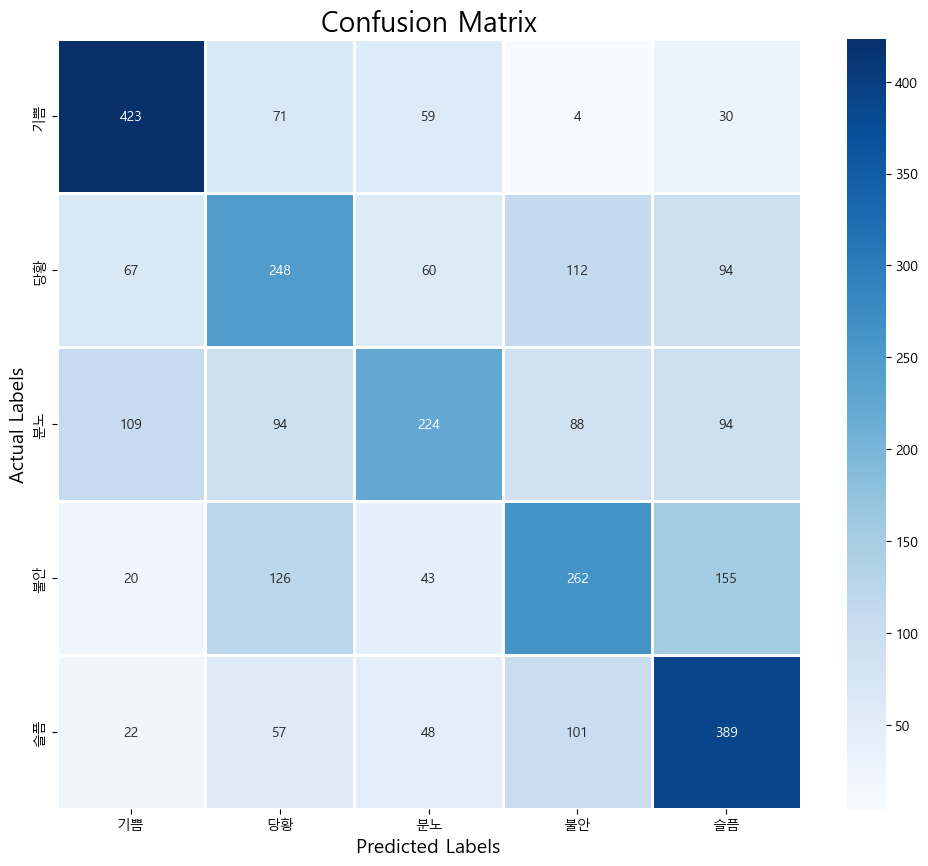

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enco.categories_] , columns = [i for i in enco.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          기쁨       0.66      0.72      0.69       587
          당황       0.42      0.43      0.42       581
          분노       0.52      0.37      0.43       609
          불안       0.46      0.43      0.45       606
          슬픔       0.51      0.63      0.56       617

    accuracy                           0.52      3000
   macro avg       0.51      0.52      0.51      3000
weighted avg       0.51      0.52      0.51      3000



#### EfficientNet 테스트 데이터 평가

In [ ]:
model.evaluate(x_pred, tY, batch_size=32)

47/47 [==============================] - 84s 2s/step - loss: 1.5659 - accuracy: 0.4320


[1.5659319162368774, 0.4320000112056732]

In [ ]:
# predicting on test data.
pred_test = model.predict(x_pred)
y_pred = enco.inverse_transform(pred_test)

y_test = enco.inverse_transform(tY)

In [ ]:
Sf = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
Sf['Predicted Labels'] = y_pred.flatten()
Sf['Actual Labels'] = y_test.flatten()


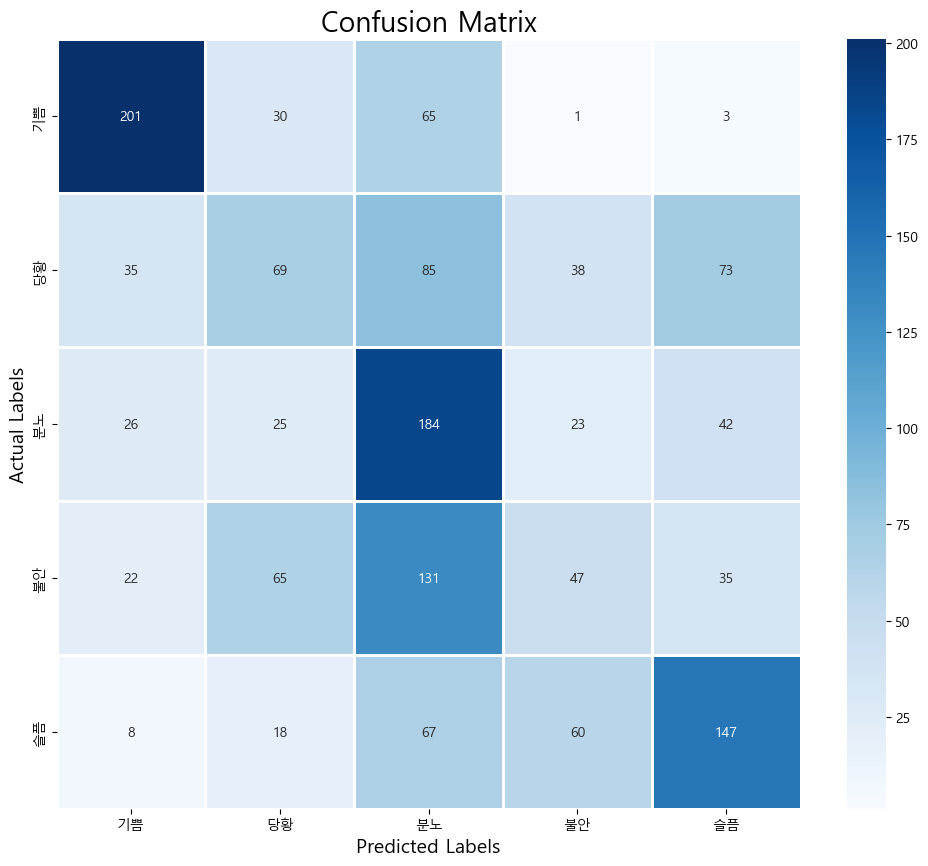

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enco.categories_] , columns = [i for i in enco.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          기쁨       0.69      0.67      0.68       300
          당황       0.33      0.23      0.27       300
          분노       0.35      0.61      0.44       300
          불안       0.28      0.16      0.20       300
          슬픔       0.49      0.49      0.49       300

    accuracy                           0.43      1500
   macro avg       0.43      0.43      0.42      1500
weighted avg       0.43      0.43      0.42      1500

